In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


# **Energy Consumption Forecastting Using XGBoost**

### **PJM Hourly Energy Consumption Data**

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW). The regions have changed over the years so data may only appear for certain dates per region.

For the purpose of our project we're going to specifically work on the **AEP_Hourly - American Electric Power** dataset.

# Import Libraries

In [2]:
# Import all the necessary Libraries 
import matplotlib.pyplot as plt # For visualization
import seaborn as sns #for visualization
import xgboost as xgb #for modelling purposes
from xgboost import plot_importance, plot_tree #Feature importance
from sklearn.metrics import mean_squared_error, mean_absolute_error #to evaluate model performance
from sklearn.preprocessing import LabelEncoder 
plt.style.use('fivethirtyeight')

### **Objective**

* Split the last year into a test set- can we can build a model to predict energy consumption.
* Find trends in energy consumption around hours of the day, holidays, or long term trends.
* Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.

## **Load Data**

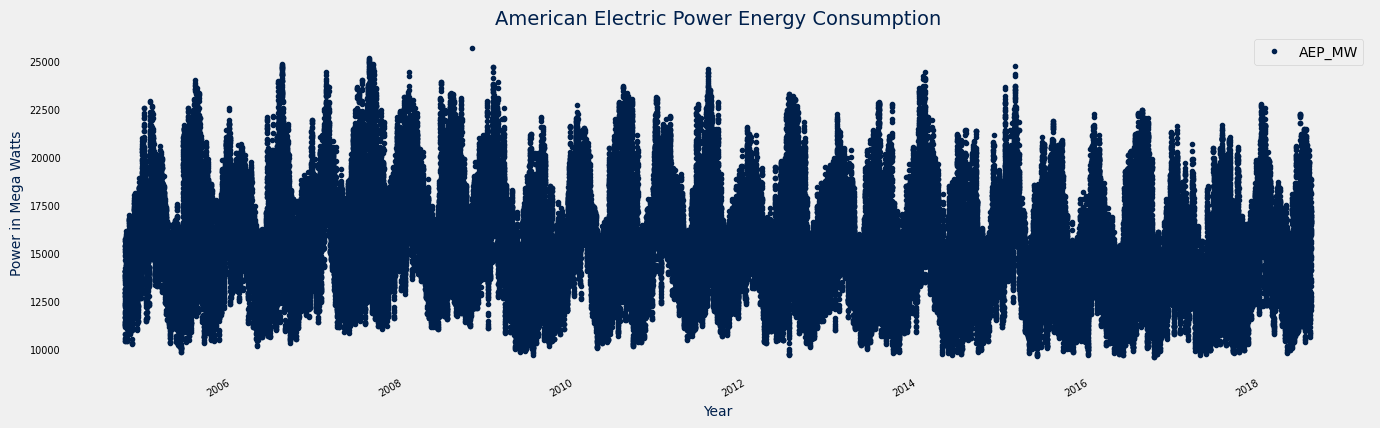

In [3]:
aep = pd.read_csv('/kaggle/input/hourly-energy-consumption/AEP_hourly.csv',index_col=[0],parse_dates=[0])
col_pal = ['#00204C', '#31446B', '#782170', '#958F78', '#00B050', '#FFE945']
_ = aep.plot(style='.',figsize=(15,5), color=col_pal[0])
plt.title('American Electric Power Energy Consumption', fontsize=14,color=col_pal[0])  # Adjust the fontsize for the title
plt.xlabel('Year', fontsize=10,color=col_pal[0])  # Adjust the fontsize for the x-axis label
plt.ylabel('Power in Mega Watts', fontsize=10,color=col_pal[0])  # Adjust the fontsize for the y-axis label
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=10)
plt.grid(False)

## **Data Exploration**

In [4]:
from IPython.display import display_html
import io

#I like seeing the descriptive information about our df
# Capture the outputs
head_output = aep.head().to_html()
describe_output = aep.describe().to_html()

# save the info output
buffer = io.StringIO()
aep.info(buf=buffer)
info_output = buffer.getvalue().replace('\n', '<br>')

# Use display side by side
display_html(f'<div style="display: flex; justify-content: space-around;">'
             f'<div>{head_output}</div>'
             f'<div>{describe_output}</div>'
             f'<div><pre>{info_output}</pre></div>'
             f'</div>', raw=True)

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065


In [5]:
# Let's copy the df for exploration
df_aep_mw = aep.copy()
df_aep_mw.head()

def analysis_features(df_aep):
    df_aep['date'] = df_aep.index
    df_aep['hour'] = df_aep['date'].dt.hour
    df_aep['dayofweek'] = df_aep['date'].dt.dayofweek
    df_aep['quarter']= df_aep['date'].dt.quarter
    df_aep['month'] = df_aep['date'].dt.month
    df_aep['year'] = df_aep['date'].dt.year
    df_aep['dayofyear'] = df_aep['date'].dt.dayofyear
    df_aep['dayofmonth'] = df_aep['date'].dt.day
    df_aep['weekofyear'] = df_aep['date'].dt.isocalendar().week
    return df_aep

In [6]:
analysis_features(df_aep_mw)
df_aep_mw.head()

,AEP_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2004-12-31 01:00:00,13478.0,2004-12-31 01:00:00,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2004-12-31 02:00:00,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,2004-12-31 03:00:00,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,2004-12-31 04:00:00,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,2004-12-31 05:00:00,5,4,4,12,2004,366,31,53


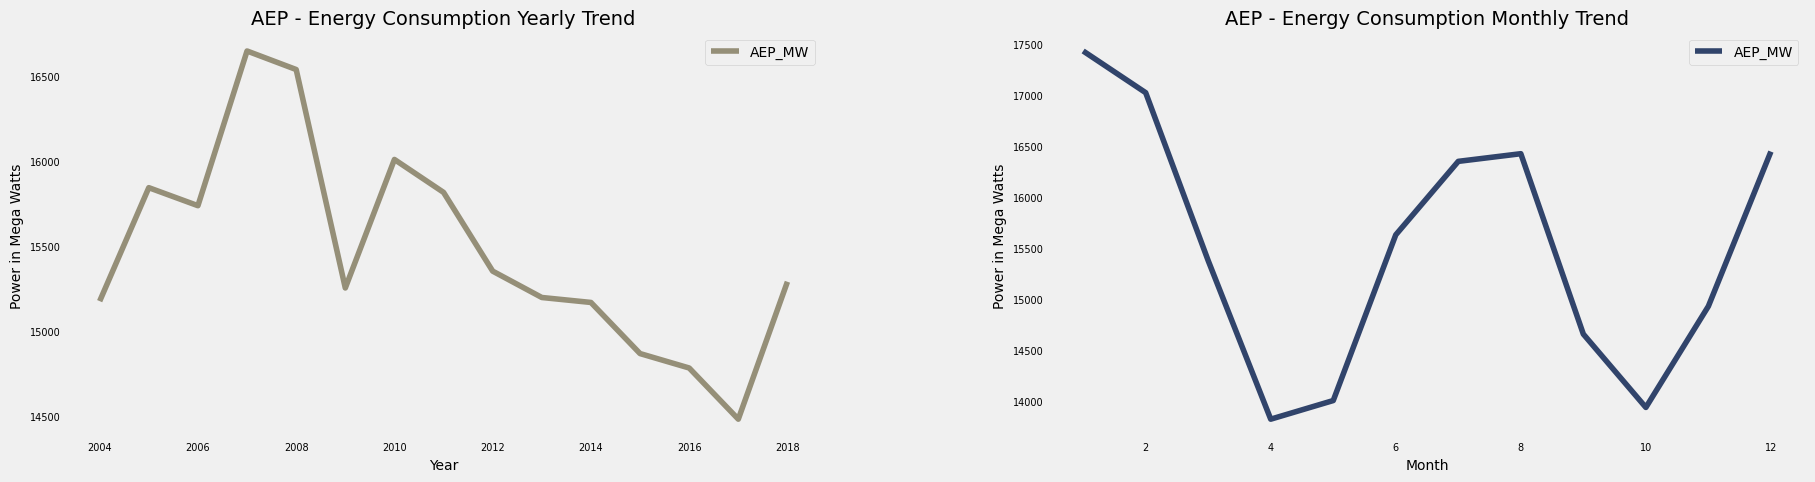

In [7]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_aep_mw.groupby(['year']).mean()['AEP_MW'].plot(color=col_pal[3])
plt.title('AEP - Energy Consumption Yearly Trend', fontsize=14)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Power in Mega Watts', fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=10)
plt.grid(False)

plt.subplot(1,2,2)
df_aep_mw.groupby(['month']).mean()['AEP_MW'].plot(color=col_pal[1])
plt.title('AEP - Energy Consumption Monthly Trend', fontsize=14) 
plt.xlabel('Month', fontsize=10) 
plt.ylabel('Power in Mega Watts', fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=10)
plt.grid(False)


plt.subplots_adjust(wspace=0.3)


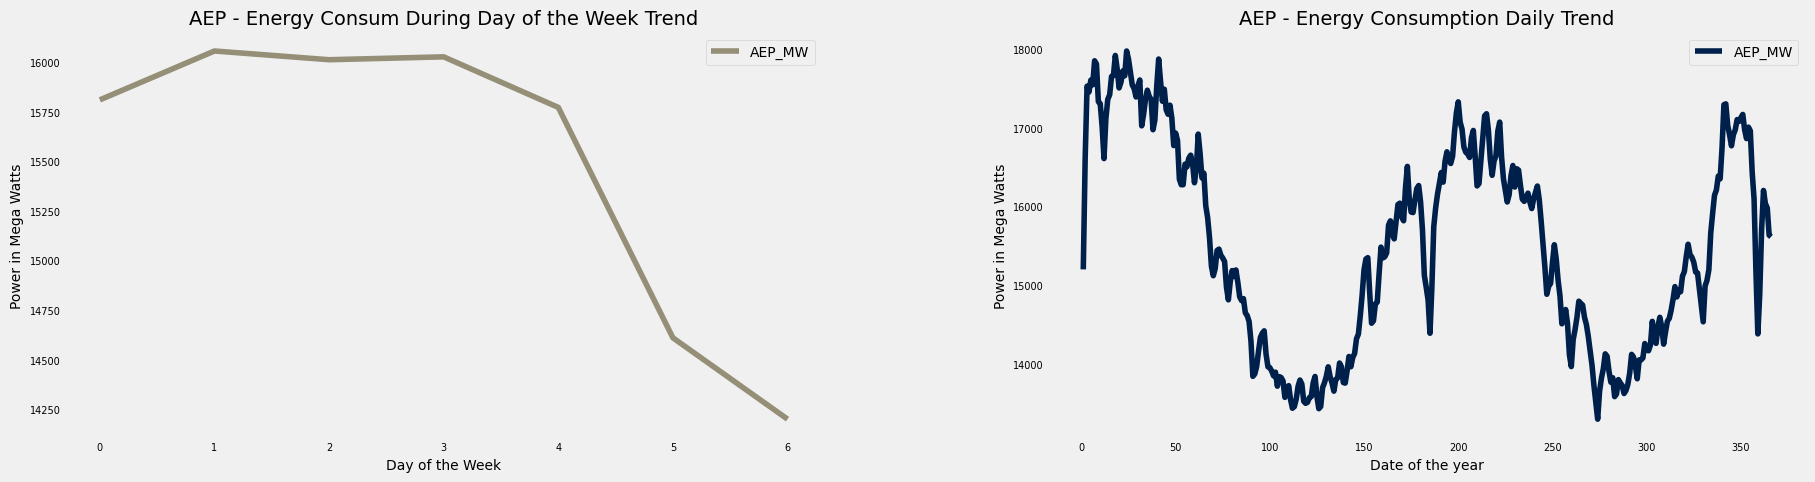

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_aep_mw.groupby(['dayofweek']).mean()['AEP_MW'].plot(color=col_pal[3])
plt.title('AEP - Energy Consum During Day of the Week Trend', fontsize=14)
plt.xlabel('Day of the Week', fontsize=10)
plt.ylabel('Power in Mega Watts', fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=10)
plt.grid(False)

plt.subplot(1,2,2)
df_aep_mw.groupby(['dayofyear']).mean()['AEP_MW'].plot(color=col_pal[0])
plt.title('AEP - Energy Consumption Daily Trend', fontsize=14) 
plt.xlabel('Date of the year', fontsize=10)  
plt.ylabel('Power in Mega Watts', fontsize=10) 
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=10)
plt.grid(False)

plt.subplots_adjust(wspace=0.3)

### **Key Insights**

* It's clear from the first chart that energy consumption has dropped **year on yaer**.
* It's also observable that energy consumption is heavly influenced by **sesonality**.
* Furthermore, the **end of the week** where the least electric energy is consumed.

## **Create New Features**

> Let's first split the dataset in first since the objective and test of the prediction will be after the dates Jan 1 of 2015. Let's do that:

In [9]:
date_of_split = '01-Jan-2015'
aep_train = aep.loc[aep.index <= date_of_split].copy()
aep_test = aep.loc[aep.index > date_of_split].copy()

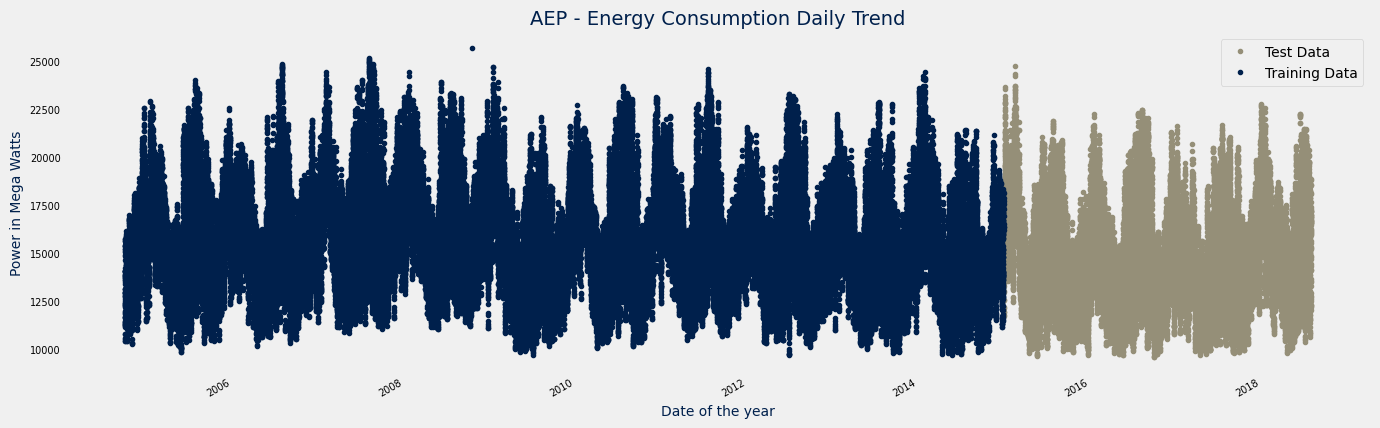

In [10]:
# A very simple way of displaying what we'll be predicting and what our model will be training on
_ = aep_test.rename(columns={'AEP_MW': 'Test Data'}).join(aep_train.rename(columns={'AEP_MW': 'Training Data'}), how='outer').plot(figsize=(15,5),style = '.',color = [col_pal[3],col_pal[0]])
plt.title('AEP - Energy Consumption Daily Trend', fontsize=14,color=col_pal[0]) 
plt.xlabel('Date of the year', fontsize=10,color = col_pal[0])  
plt.ylabel('Power in Mega Watts', fontsize=10,color = col_pal[0])
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=10)
plt.grid(False)

In [11]:
import holidays

start_date = '2004-10-01'
end_date = '2018-08-31'

# date range
date_range = pd.date_range(start=start_date, end=end_date)

# holidays for the date range
us_holidays = holidays.US(years=range(2004, 2019))

# Convert the holiday dates to a list
holidays = list(us_holidays.keys())

In [12]:

def new_features(df, label=None, lags=[1, 7, 30], rolling_windows=[3, 7, 30]):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    # Our lag features
    for lag in lags:
        df[f'lag_{lag}'] = df[label].shift(lag)

    # rollling statistics
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df[label].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df[label].rolling(window=window).std()

    # Seasonal indicators
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_holiday'] = df['date'].apply(lambda x: 1 if x in holidays else 0)  # 'holidays' is a list of holidays that would have occured with in our df.

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
           'is_weekend', 'is_holiday'] +
           [f'lag_{lag}' for lag in lags] +
           [f'rolling_mean_{window}' for window in rolling_windows] +
           [f'rolling_std_{window}' for window in rolling_windows]]
    
    if label:
        y = df[label]
        return X, y
    return X


In [13]:
X_train, y_train = new_features(aep_train, label='AEP_MW')
X_test, y_test = new_features(aep_test, label='AEP_MW')
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_holiday,lag_1,lag_7,lag_30,rolling_mean_3,rolling_mean_7,rolling_mean_30,rolling_std_3,rolling_std_7,rolling_std_30
Datetime,,,,,,,,,,,,,,,,,,,
2004-12-31 01:00:00,1,4,4,12,2004,366,31,53,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-31 02:00:00,2,4,4,12,2004,366,31,53,0,0,13478.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-31 03:00:00,3,4,4,12,2004,366,31,53,0,0,12865.0,NaN,NaN,12973.333333,NaN,NaN,460.165550,NaN,NaN
2004-12-31 04:00:00,4,4,4,12,2004,366,31,53,0,0,12577.0,NaN,NaN,12653.000000,NaN,NaN,186.032255,NaN,NaN
2004-12-31 05:00:00,5,4,4,12,2004,366,31,53,0,0,12517.0,NaN,NaN,12588.000000,NaN,NaN,77.090855,NaN,NaN


In [14]:
print("Length of X_test:", len(X_test))
print("Length of aep_test:", len(aep_test))
print("Length of X_train:", len(X_train))
print("Length of aep_train:", len(aep_train))

Length of X_test: 31439
Length of aep_test: 31439
Length of X_train: 89834
Length of aep_train: 89834


In [15]:
#I like seeing the descriptive information about our 
# save the outputs
head_output2 = X_train.head().T.to_html()
describe_output2 = X_train.describe().T.to_html()

# save the info output
buffer = io.StringIO()
X_train.info(buf=buffer)
info_output2 = buffer.getvalue().replace('\n', '<br>')

# Use HTML to display side by side
display_html(f'<div style="display: flex; justify-content: space-around;">'
             f'<div>{head_output2}</div>'
             f'<div>{describe_output2}</div>'
             f'<div><pre>{info_output2}</pre></div>'
             f'</div>', raw=True)

Datetime,2004-12-31 01:00:00,2004-12-31 02:00:00,2004-12-31 03:00:00,2004-12-31 04:00:00,2004-12-31 05:00:00
hour,1,2,3,4,5
dayofweek,4,4,4,4,4
quarter,4,4,4,4,4
month,12,12,12,12,12
year,2004,2004,2004,2004,2004
dayofyear,366,366,366,366,366
dayofmonth,31,31,31,31,31
weekofyear,53,53,53,53,53
is_weekend,0,0,0,0,0
is_holiday,0,0,0,0,0


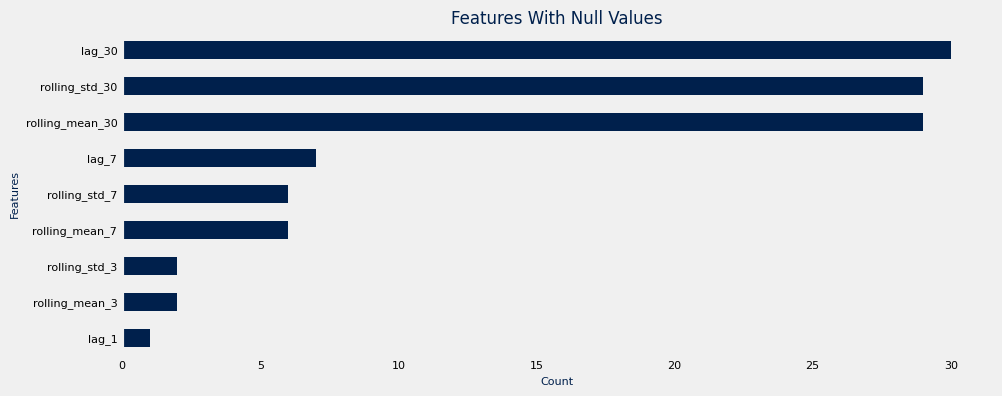

In [16]:
missing_values = X_train.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(ascending=True).plot(kind='barh', figsize=(10, 4), color= col_pal[0])
plt.title('Features With Null Values', fontsize=12, color = col_pal[0])
plt.xlabel('Count',fontsize=8,color =  col_pal[0])
plt.ylabel('Features',fontsize=8,color =  col_pal[0])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(False)

In [17]:

%%capture 
# List of columns to change data types as well as handle missing values
cols_to_handle = ['lag_1', 'lag_7', 'lag_30', 'rolling_mean_3', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_3', 'rolling_std_7', 'rolling_std_30', 'weekofyear', 'is_weekend', 'is_holiday']

# Handle the missing values
X_train[cols_to_handle] = X_train[cols_to_handle].interpolate(method='linear', limit_direction='forward').fillna(0);
X_test[cols_to_handle] = X_test[cols_to_handle].interpolate(method='linear', limit_direction='forward').fillna(0);

# Convert columns to int32 so that dt is uniform all across the df
for col in cols_to_handle:
    X_train[col] = X_train[col].astype('int32')
    X_test[col] = X_test[col].astype('int32')


# **Create Model**

 For this project, we’re going to use **XGBoost**'s Algorithm, specifically **XGBRegressor**. **XGBRegressor** is a specialized implementation of the XGBoost algorithm designed for regression tasks. **Regression** tasks involve predicting continuous numerical values, such as forecasting sales or estimating prices. **XGBoost** stands for **Extreme Gradient Boosting**, which is a powerful machine learning technique known for its high performance and flexibility. **XGBRegressor** is tailored to handle regression problems effectively by leveraging the core principles of gradient boosting, making it suitable for various predictive modeling tasks where the goal is to predict a continuous output.

 **XGBoost** builds on the concept of gradient boosting, where multiple simple models, usually decision trees, are combined to create a stronger predictive model. Each decision tree in the ensemble corrects the errors of the previous ones, gradually improving the model’s performance. This process results in a robust model capable of capturing complex patterns in the data, which is particularly useful for tasks such as time series forecasting, where understanding intricate temporal dependencies is crucial.

In [18]:
%%capture 

#Let's create a class for our model from xgb
xgb_model = xgb.XGBRegressor(n_estimators=1000)
#xgb_model.fit(X_train,y_train,eval_set = [(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50, verbose=False) # The verbose allows us to not see the model training.
xgb_model.fit(X_train,y_train) # The verbose allows us to not see the model training.

<Figure size 2000x1000 with 0 Axes>

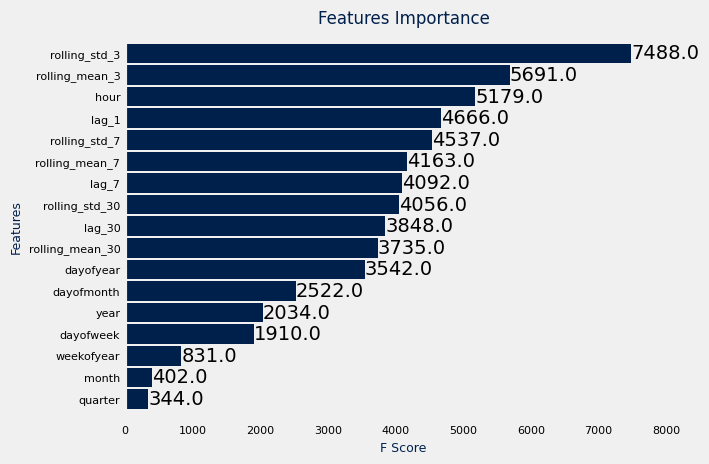

In [19]:
# Now we plot an F score of how important each of our features are
plt.figure(figsize=(20,10))
ax = plot_importance(xgb_model, height=0.9,color =col_pal[0])
plt.title('Features Importance', fontsize=12, color = col_pal[0])
plt.xlabel('F Score',fontsize=9,color =  col_pal[0])
plt.ylabel('Features',fontsize=9,color =  col_pal[0])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(False)



## Prediction

In [20]:
aep_test['Aep_Predictions'] = xgb_model.predict(X_test)
aep_comb = pd.concat([aep_test, aep_train],sort=False)

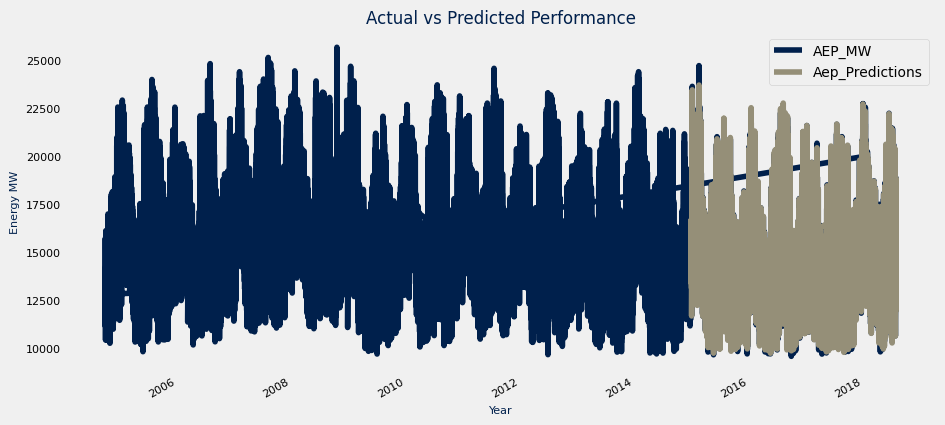

In [21]:
_ = aep_comb[['AEP_MW','Aep_Predictions']].plot(figsize=(10,5),color = [col_pal[0],col_pal[3]])
plt.title('Actual vs Predicted Performance', fontsize=12, color = col_pal[0])
plt.xlabel('Year',fontsize=8,color =  col_pal[0])
plt.ylabel('Energy MW',fontsize=8,color =  col_pal[0])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=10)
plt.grid(False)

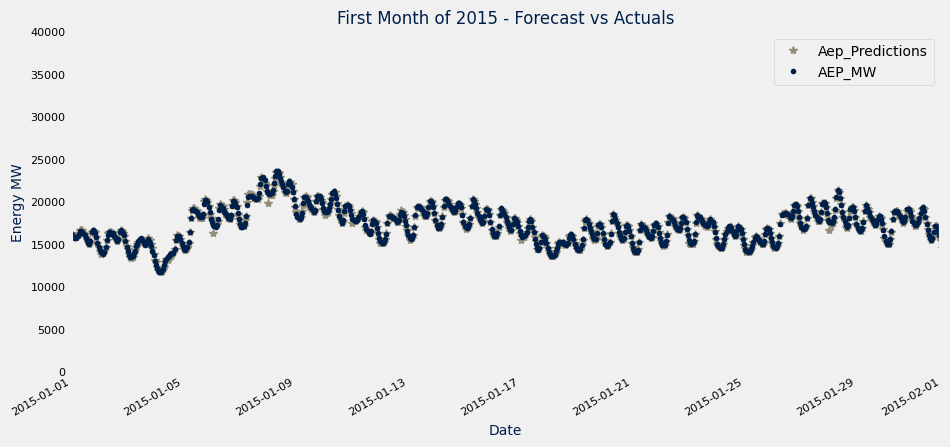

In [22]:
# Let's compare the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = aep_comb[['Aep_Predictions','AEP_MW']].plot(ax=ax,style=['*','.'],color = [col_pal[3],col_pal[0]])
ax.set_xbound(lower='01-01-2015',upper='02-01-2015')
ax.set_ylim(0,40000)
plt.title('First Month of 2015 - Forecast vs Actuals', fontsize=12, color = col_pal[0])
plt.xlabel('Date',fontsize=10,color =  col_pal[0])
plt.ylabel('Energy MW',fontsize=10,color =  col_pal[0])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=10)
plt.grid(False)

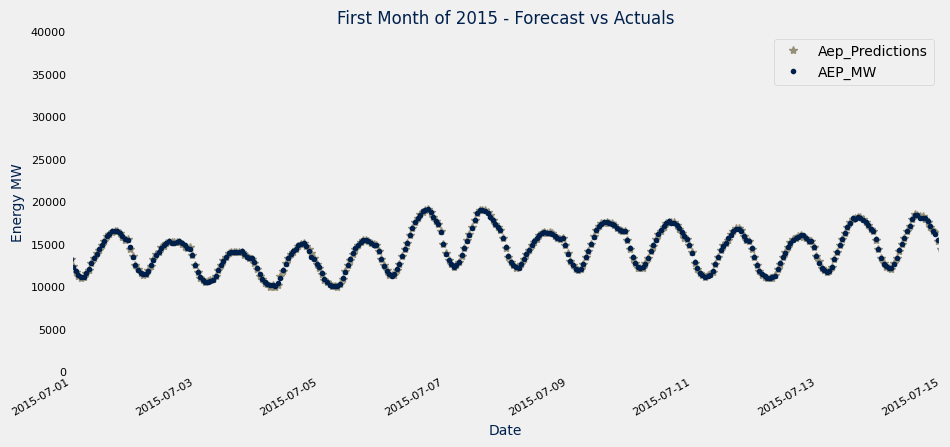

In [23]:
# Let's compare the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = aep_comb[['Aep_Predictions','AEP_MW']].plot(ax=ax,style=['*','.'],color = [col_pal[3],col_pal[0]])
ax.set_xbound(lower='07-01-2015',upper='07-15-2015')
ax.set_ylim(0,40000)
plot = plt.title('First Two Weeks of 2015 Forecast vs Actuals')
plt.title('First Month of 2015 - Forecast vs Actuals', fontsize=12, color = col_pal[0])
plt.xlabel('Date',fontsize=10,color =  col_pal[0])
plt.ylabel('Energy MW',fontsize=10,color =  col_pal[0])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=10)
plt.grid(False)


## **Model Performance & Error Metrics**

In [24]:
mse = mean_squared_error(y_true=aep_test['AEP_MW'],y_pred=aep_test['Aep_Predictions'])
mae = mean_absolute_error(y_true=aep_test['AEP_MW'],y_pred=aep_test['Aep_Predictions'])

print("The Mean Ssquare Error is: ", round(mse,2))
print("The Mean Absolute Error is: ", round(mae,2))

The Mean Ssquare Error is:  11750.01
The Mean Absolute Error is:  68.59


In [25]:
def mean_abs_perc_error(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

mape = mean_abs_perc_error(y_true=aep_test['AEP_MW'], y_pred=aep_test['Aep_Predictions'])
print("The Mean Absolute Percentage Error is: ", round(mape,2),"%")


The Mean Absolute Percentage Error is:  0.48 %


In [26]:
aep_test['error_difference'] = aep_test['AEP_MW'] - aep_test['Aep_Predictions']
aep_test['error_absolute'] = aep_test['error_difference'].apply(np.abs)
aep_test['error_percentage'] = ((aep_test['AEP_MW'] - aep_test['Aep_Predictions']) / aep_test['AEP_MW'])*100
aep_test['error_absolute_perc'] =  (np.abs(aep_test['AEP_MW'] - aep_test['Aep_Predictions']) / aep_test['AEP_MW'])*100
errors_ = aep_test.groupby(['year','month','dayofmonth']).mean()[['AEP_MW','Aep_Predictions','error_difference','error_absolute','error_percentage','error_absolute_perc']]

#The forecasted values
errors_.sort_values('error_difference',ascending=True).head(10)

AEP_MW  Aep_Predictions  error_difference  \
year month dayofmonth                                                    
2015 12    25          11078.041667     11361.145508       -283.103963   
           24          11466.041667     11636.549805       -170.507975   
           27          11998.916667     12167.000000       -168.082682   
2016 10    2           11264.000000     11420.069336       -156.068929   
           9           11309.083333     11460.838867       -151.755859   
2018 4     24          11723.750000     11859.819336       -136.068481   
2016 4     23          11366.958333     11483.020508       -116.062826   
2015 11    27          11755.083333     11860.136719       -105.053874   
2017 4     16          11400.291667     11494.026367        -93.734741   
2016 5     8           11171.083333     11258.855469        -87.772298   

                       error_absolute  error_percentage  error_absolute_perc  
year month dayofmonth                                                         
2015 12    25              294.095337         -2.718336             2.813941  
           24              178.117350         -1.556654             1.621767  
           27              255.303792         -1.359103             2.068011  
2016 10    2               195.253011         -1.551241             1.875590  
           9               171.619629         -1.480253             1.640582  
2018 4     24              157.635457         -1.286295             1.464491  
2016 4     23              133.451172         -1.094378             1.239339  
2015 11    27              114.566243         -0.898100             0.983253  
2017 4     16              121.559448         -0.910499             1.146842  
2016 5     8               101.725260         -0.853027             0.970991

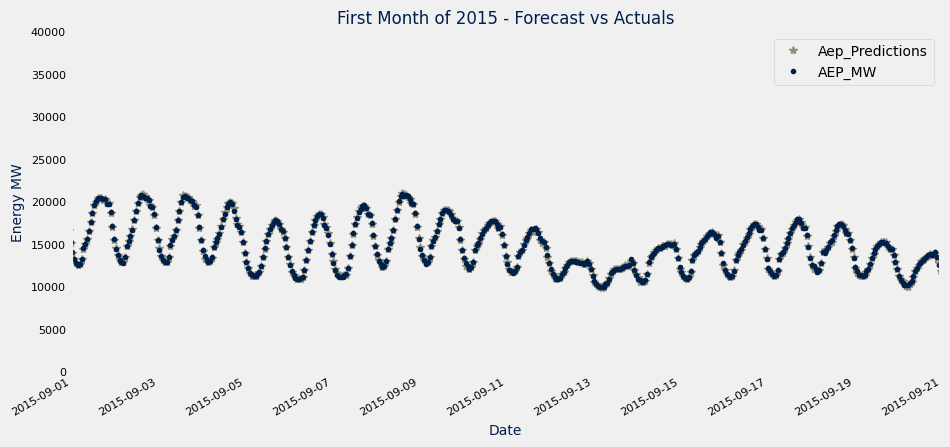

In [27]:
#Let's see some of the best predicted days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = aep_comb[['Aep_Predictions','AEP_MW']].plot(ax=ax,style=['*','.'],color = [col_pal[3],col_pal[0]])
ax.set_ylim(0, 40000)
ax.set_xbound(lower='09-01-2015',upper='09-21-2015')
plot = plt.title('Septemeber First Three Weeks - Bad Predictions')
plt.title('First Month of 2015 - Forecast vs Actuals', fontsize=12, color = col_pal[0])
plt.xlabel('Date',fontsize=10,color =  col_pal[0])
plt.ylabel('Energy MW',fontsize=10,color =  col_pal[0])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=10)
plt.grid(False)

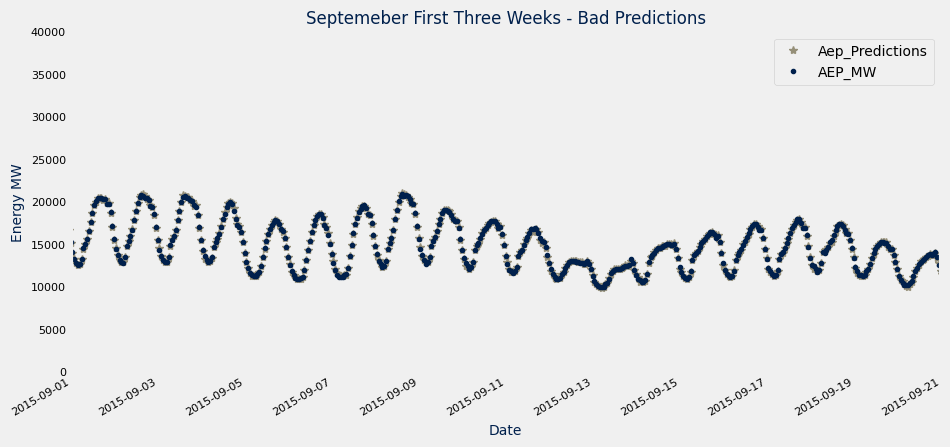

In [28]:
#Let's see some of the best predicted days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = aep_comb[['Aep_Predictions','AEP_MW']].plot(ax=ax,style=['*','.'],color = [col_pal[3],col_pal[0]])
ax.set_ylim(0, 40000)
ax.set_xbound(lower='11-01-2015',upper='11-21-2015')
ax.set_xbound(lower='09-01-2015',upper='09-21-2015')
plt.title('Septemeber First Three Weeks - Bad Predictions', fontsize=12, color = col_pal[0])
plt.xlabel('Date',fontsize=10,color =  col_pal[0])
plt.ylabel('Energy MW',fontsize=10,color =  col_pal[0])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=10)
plt.grid(False)